In [1]:
from brillouin_analyzer_src import *
%load_ext autoreload
%autoreload 2

# Parse Data

In [2]:
base_path = "./example_data/"
parsed_data = parse_brillouin_set(base_path + "example_data.zip", "Raghavan_Rounder_cells_low_dens_glass_2")

# Analyze Data
Here first we need to manually find the laser peaks indexes. By running PCA we can find that they are 589, 959, 1246, 1489.

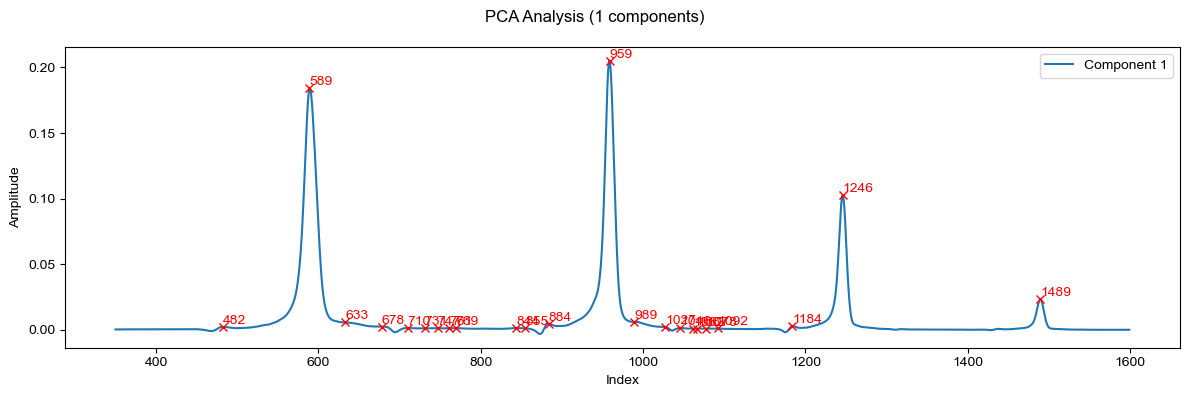

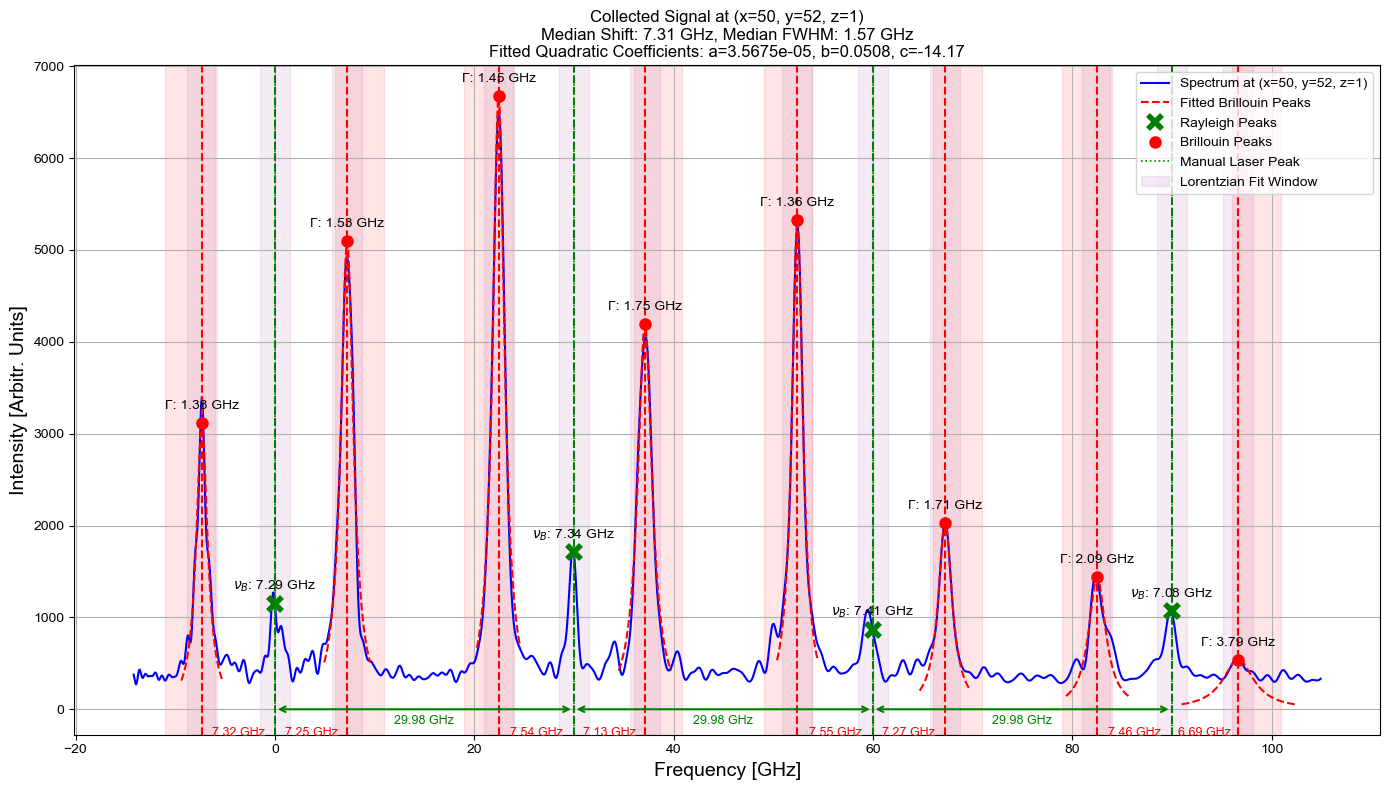

{'df':            Peak  Peak Index        Peak Type     Shift      FWHM  \
 0   1151.030089         589            Laser  7.285512  1.458808   
 1   3398.997728         474   Brillouin Left  7.324087  1.384116   
 2   4934.795987         690  Brillouin Right  7.246937  1.533501   
 3   1711.117506         959            Laser  7.337457  1.602897   
 4   6487.405904         876   Brillouin Left  7.541494  1.452655   
 5   4055.144971        1033  Brillouin Right  7.133419  1.753140   
 6    864.725232        1246            Laser  7.411486  1.533154   
 7   5262.035655        1179   Brillouin Left  7.553879  1.355967   
 8   2033.567334        1308  Brillouin Right  7.269094  1.710341   
 9   1067.355713        1489            Laser  7.075261  2.938798   
 10  1406.688731        1432   Brillouin Left  7.458614  2.089837   
 11   560.739904        1539  Brillouin Right  6.691907  3.787760   
 
     Center (GHz)    Amplitude  Gamma (GHz)    Fit RMSE  
 0       0.000122  1151.030089     1.

In [3]:
filter_settings = [
    {'type': 'savgol', 'params': (15, 6)},
    {'type': 'wavelet', 'wavelet': 'db6', 'level': 5},
    {'type': 'fft', 'params': (20, 100)}
]

analyze_brillouin_spectrum_manual(
brillouin_spectra=parsed_data,
laser_peak_ranges=[589, 959, 1246, 1489],
brillouin_peak_ranges=(6, 11),
debug_plot=True,
fit_lorentzians=1.5,
fwhm_bounds_GHz=(0.8, 4.0),
center_slack_GHz=0.5,
make_plot=(14, 8),
save_plot=True,
plot_PCA=True,
pca_n_components=1,
pca_peak_finding_params={"height": 0.001},
filter_settings=filter_settings,
match_brilouin_parameters=False
)

After finding the laser peaks we can run the analysis.

In [4]:
peaks_maps = analyze_brillouin_spectra_manual(
# x_coord=58, y_coord=4, z_coord=2,
brillouin_spectra=parsed_data,
laser_peak_ranges=[589, 959, 1246, 1489],
brillouin_peak_ranges=(6, 11),
fit_lorentzians=1.5,
fwhm_bounds_GHz=(0.8, 4.0),
center_slack_GHz=0.5,
filter_settings=filter_settings,
max_workers=12,
parallel_backend="process",
laser_refit=True,
match_brilouin_parameters=True
)

Processing 11163 pixels across 3 z slices...


Laser pre-pass:   0%|          | 0/11163 [00:00<?, ?it/s]

Processing Brillouin Shift and FWHM:   0%|          | 0/11163 [00:00<?, ?it/s]

No pixels to refit.


# Plot heatmaps.

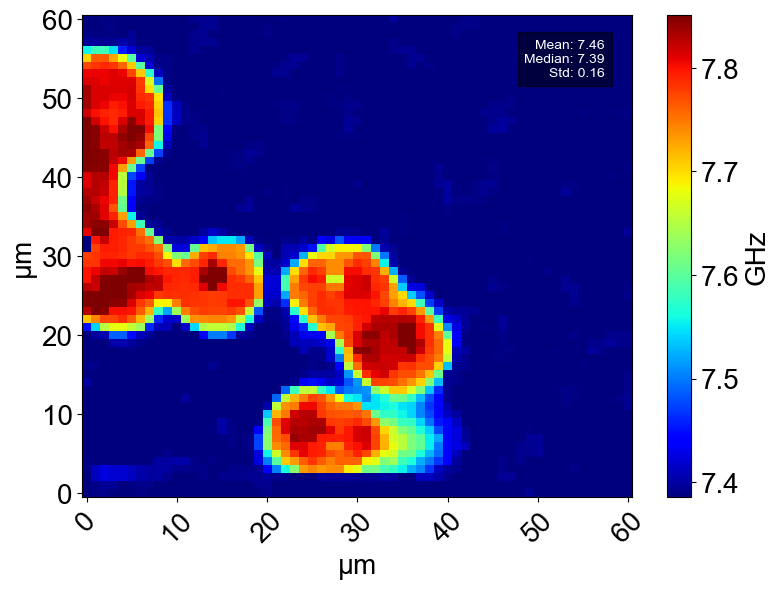

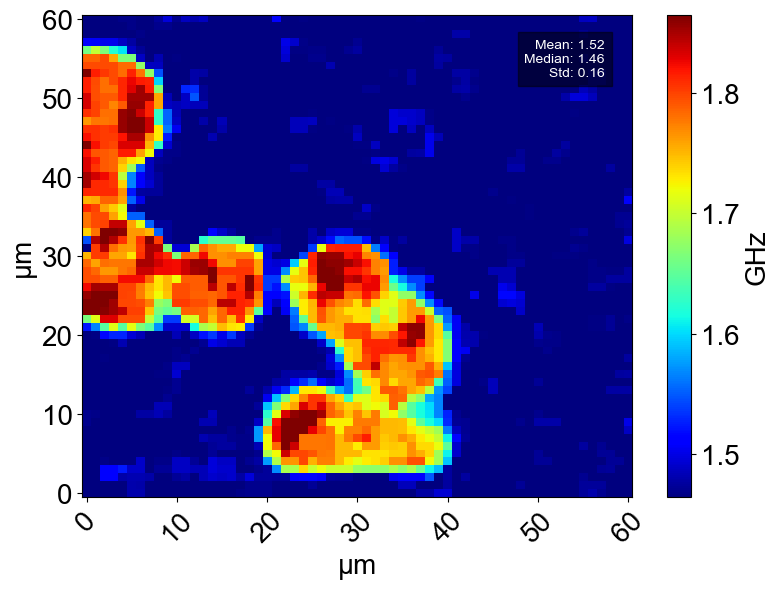

In [5]:
dataset_ready = peaks_maps[1]
plot_brillouin_heatmap(
    dataset_ready,
    '',
    data_type="Shift",  # 'Shift' or 'FWHM'
    peak_type='Brillouin',  # The peak type to extract
    aggregation='median',  # 'median', 'mean', or 'robust'
    filter_type='median',
    filter_params={'size': 3},  # Parameters for the filter
    interpolate_nan=True,
    colorbar_range=("auto", 60, 99),
    cmap='jet',
    interpolation=None,
    annotate=True,
    match_type='contains',  # 'exact' or 'contains'
    scale='auto',
    pixel_aggregation='median'
)

plot_brillouin_heatmap(
    dataset_ready,
    '',
    data_type="FWHM",  # 'Shift' or 'FWHM'
    peak_type='Brillouin',  # The peak type to extract
    aggregation='median',  # 'median', 'mean', or 'robust'
    filter_type='median',
    filter_params={'size': 3},  # Parameters for the filter
    interpolate_nan=True,
    colorbar_range=("auto", 60, 99),
    cmap='jet',
    interpolation=None,
    annotate=True,
    match_type='contains',  # 'exact' or 'contains'
    scale='auto',
    pixel_aggregation='median'
)

# Find regions of interest.

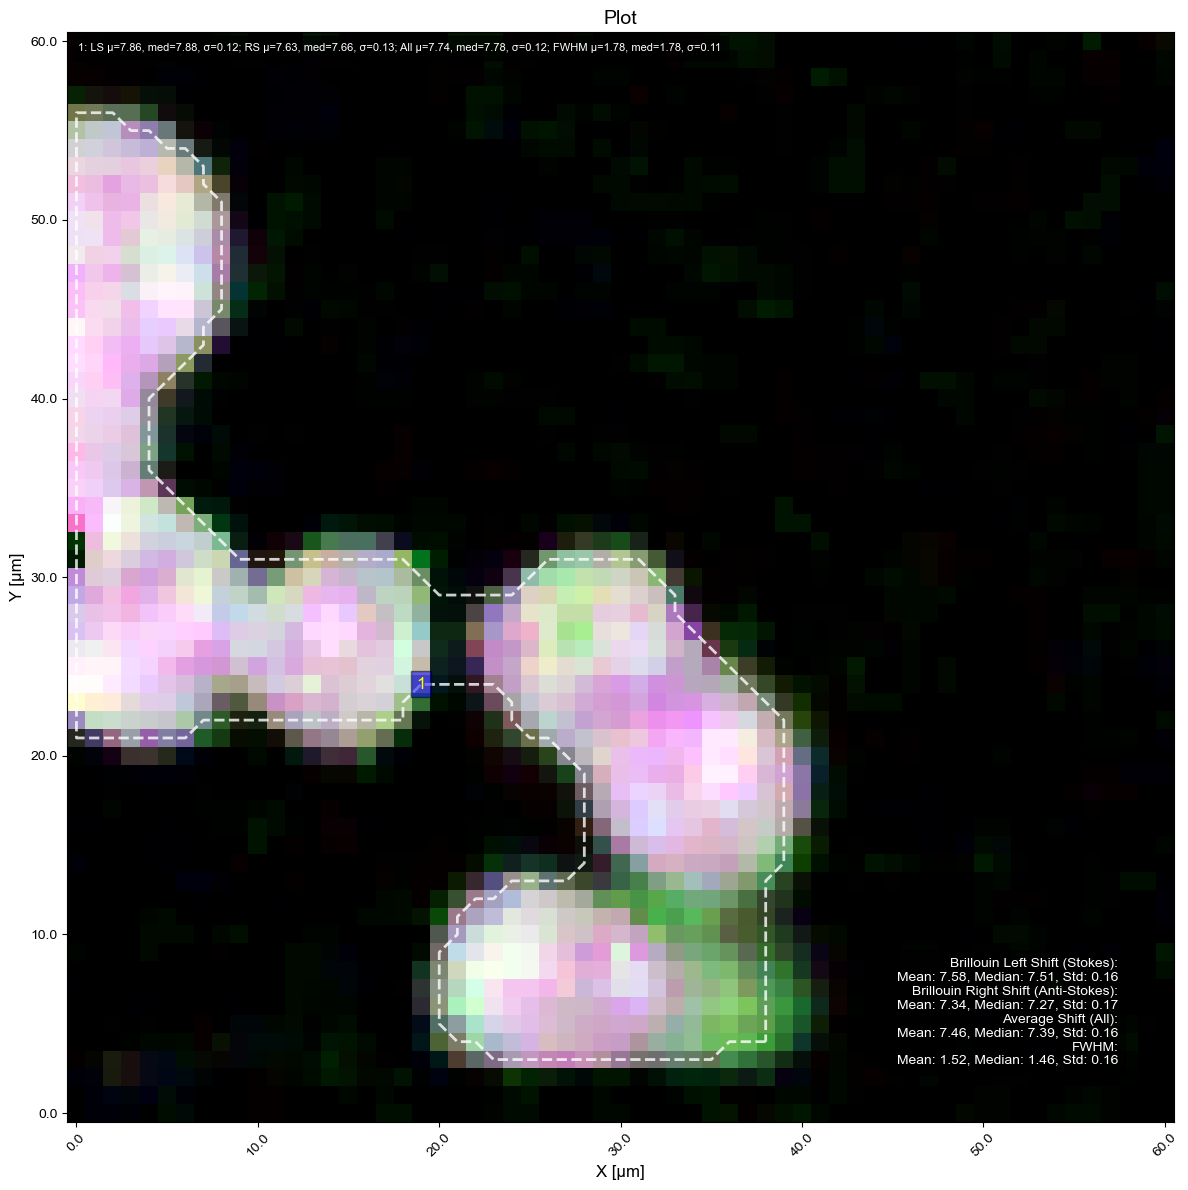

In [6]:
import cv2
cells_data = detect_cells(  
    peaks_maps[1],
    title = 'Plot',
    filter_type='median',
    filter_params={'size': 3},
    interpolate_nan=False,
    aggregation='median',
    normalize=True,
    pre_gaussian_blur=True,
    morph_op=True,
    annotate=True,
    save_fig=True,
    fig_path=None,
    save_csv=None,
    cell_area=[0, 1000],  # [min_area, max_area]
    threshold_method='otsu',  # 'otsu', 'adaptive', 'fixed', or 'manual'
    threshold_value=None,      # Threshold value if using 'fixed'
    manual_regions=None,       # List of regions: {'type':'polygon','points':[...] } or {'type':'circle','center':(x,y),'radius':r}
    contour_retrieval_mode=cv2.RETR_EXTERNAL,  # Contour retrieval mode
    contour_smoothing=0.001,  # Approximation factor for contour smoothing
    prominence=0.1,
    shift_range=('auto', 60, 99),
    fwhm_range=('auto', 60, 99),
    scaling_factor='auto',
    mark_all=False,
    pixel_aggregation='mean'   # New parameter for per-pixel aggregation
)

# Plot boxplots.

Statistical Test Results:
Between 'Cells' and 'Background':
  t-test: statistic = 86.3781, p-value = 0.00000000


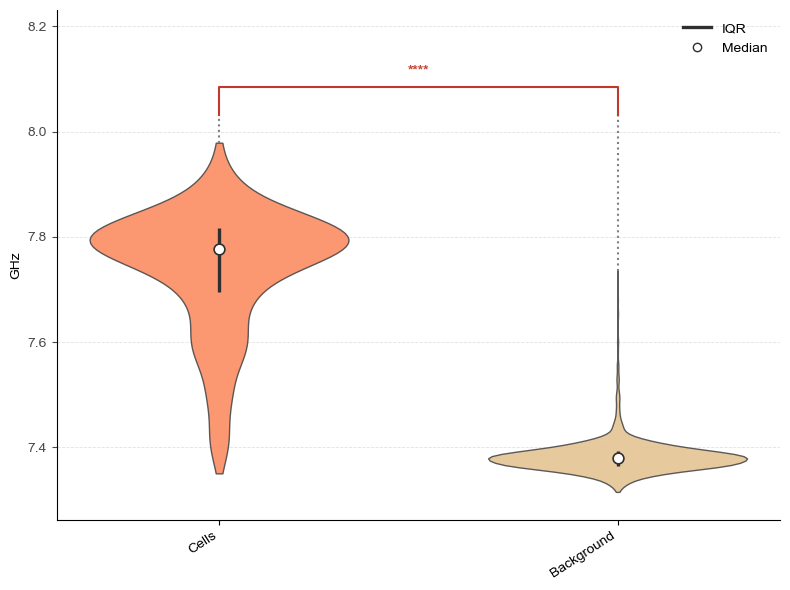

Statistical Test Results:
Between 'Cells' and 'Background':
  t-test: statistic = 78.5604, p-value = 0.00000000


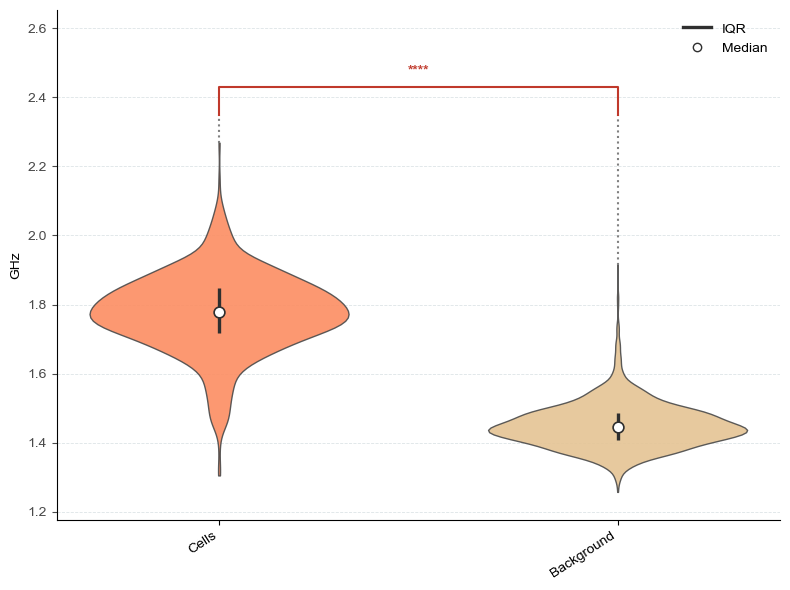

In [7]:
import numpy as np
plot_cell_boxplot(
        [[[cells_data]]],  
        ['Cells'],
        data_type='shift',
        shift_type='all',
        title='',
        plot_background=True,
        show_data_points=False,
        annotate_medians=False,
        aggregate_per_cell='pixel',  # Accept 'pixel', 'cell', or 'both'
        aggregate_func=np.nanmean,
        plot_type='violin',  # Updated to accept 'box', 'violin', or 'errorbar'
        plot_size=(8, 6),
        plot_p_values=True,
        comparisons=[(0,1)],
        p_value_source='pixel',  # 'pixel' or 'cell'
        test_type='ttest',  # 'mannwhitney', 'ttest', or 'both'
        p_value_format='stars'  # 'numeric' or 'stars'
    )
plot_cell_boxplot(
        [[[cells_data]]], 
        ['Cells'],
        data_type='FWHM',
        shift_type='all',
        title='',
        plot_background=True,
        show_data_points=False,
        annotate_medians=False,
        aggregate_per_cell='pixel',  # Accept 'pixel', 'cell', or 'both'
        aggregate_func=np.nanmean,
        plot_type='violin',  # Updated to accept 'box', 'violin', or 'errorbar'
        plot_size=(8, 6),
        plot_p_values=True,
        comparisons=[(0,1)],
        p_value_source='pixel',  # 'pixel' or 'cell'
        test_type='ttest',  # 'mannwhitney', 'ttest', or 'both'
        p_value_format='stars'  # 'numeric' or 'stars'
    )